In [301]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [302]:
channel = 10

In [303]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [304]:
PATH = f'../Dati/Run_ch{channel}_Cs_Measurements_Only_3_27_2024_0000.root'
#PATH = '../Dati/21-03/Run_ch' + str(channel) + '_Cs_Measurements_Only_3_21_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

#noise_file = '../Dati/21-03/Run_ch' + str(channel) + '_X_Measurements_Only_3_21_2024_0000.root'  #File di rumore di riferimento per il canale
noise_file = f'../Dati/Run_ch{channel}_X_Measurements_Only_3_21_2024_0000.root'
RunNoise = uproot.open(noise_file)  #Apertura rumore

In [305]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

In [306]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 10 = 674300
#Noise ripulita su ch 10 = 26103


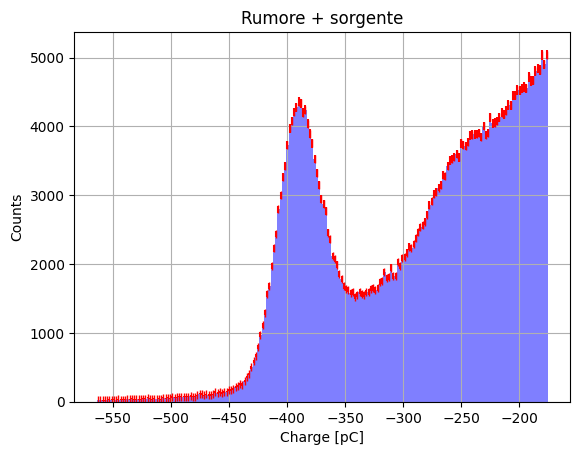

In [307]:
Nbin = 200
bin_lims = [int(Nbin *45 / 100), int(Nbin * 85 / 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


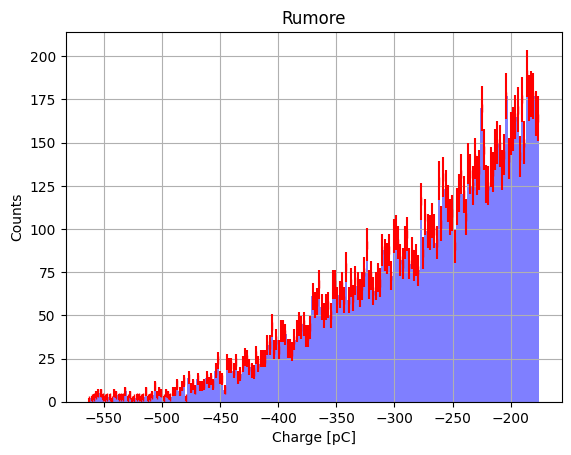

12122.0

In [308]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()


In [309]:
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

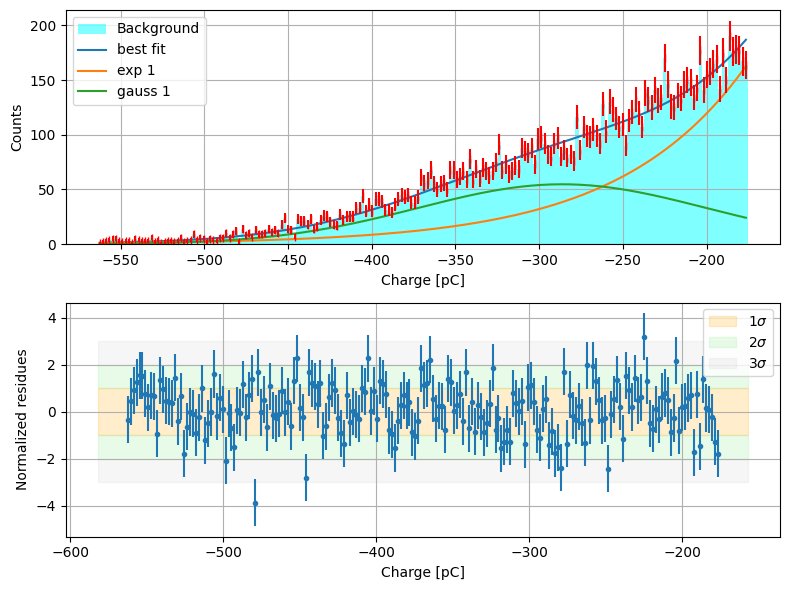

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(step, prefix='s1_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 182
    # data points      = 200
    # variables        = 5
    chi-square         = 225.173922
    reduced chi-square = 1.15473806
    Akaike info crit   = 33.7111449
    Bayesian info crit = 50.2027317
    R-squared          = 0.97388735
[[Variables]]
    e1_amplitude:  1652.73961 +/- 257.583852 (15.59%) (init = 2554.725)
    e1_decay:     -76.1062131 +/- 6.53349709 (8.58%) (init = -83.77244)
    g1_amplitude:  11788.7221 +/- 2629.16198 (22.30%) (init = 35196.82)
    g1_center:    -286.268211 +/- 11.5863372 (4.05%) (init = -228.81)
    g1_sigma:      85.8793203 +/- 7.78385841 (9.06%) (init = 62.07551)
    g1_fwhm:       202.230341 +/- 18.3295855 (9.06%) == '2.3548200*g1_sigma'
    g1_height:     54.7631244 +/- 7.47812201 (13.66%) == '0.3989423*g1_am

In [310]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
#fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac
sigmoid = StepModel(form = "logistic", prefix = "s1_") #Sigmoide


 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(gauss1.guess(binN, x=centersN))   #Indovina i parametri della prima gaussiana
params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
#params.update(fd1.make_params(amplitude = 0, center = -200, kt = -15))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)
params.update(sigmoid.make_params(amplitude = 0, center = -200, sigma = 50))

params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False
params["s1_amplitude"].vary = False
params["s1_center"].vary = False
params["s1_sigma"].vary = False
#params["fd1_amplitude"].vary = False
#params["fd1_center"].vary= False
#params["fd1_kt"].vary = False

model = exp1 + gauss1 + gauss2 + sigmoid

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1 / errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['g1_'], label='gauss 1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|')
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [311]:
params.update(result.params)
params

name,value,standard error,relative error,initial value,min,max,vary,expression
e1_amplitude,1652.73961,257.583852,(15.59%),2554.725087686687,-inf,inf,True,
e1_decay,-76.1062131,6.53349709,(8.58%),-83.77244497242962,-inf,inf,True,
g1_amplitude,11788.7221,2629.16198,(22.30%),35196.81526565552,-inf,inf,True,
g1_center,-286.268211,11.5863372,(4.05%),-228.81004880509286,-inf,inf,True,
g1_sigma,85.8793203,7.78385841,(9.06%),62.07551193237305,0.00000000,inf,True,
g1_fwhm,202.230341,18.3295855,(9.06%),146.1766570085907,-inf,inf,False,2.3548200*g1_sigma
g1_height,54.7631244,7.47812201,(13.66%),226.2002841,-inf,inf,False,"0.3989423*g1_amplitude/max(1e-15, g1_sigma)"
g2_amplitude,0.00000000,0.00000000,,0.0,-inf,inf,False,
g2_center,-320.000000,0.00000000,(0.00%),-320.0,-inf,inf,False,
g2_sigma,25.0000000,0.00000000,(0.00%),25.0,0.00000000,inf,False,


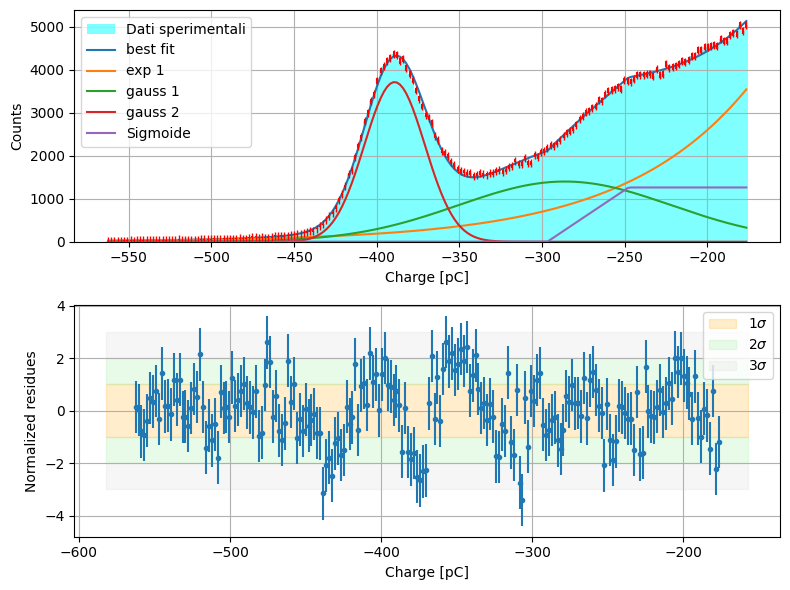

In [312]:
params["g1_sigma"].vary = True   #Blocco i parametri dell'esponenziale e della prima gaussiana
params["g1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False

params["g2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["g2_center"].vary = True
params["g2_sigma"].vary = True
params["s1_amplitude"].vary = True
params["s1_center"].vary = True
params["s1_sigma"].vary = True
#params["fd1_amplitude"].vary = True
#params["fd1_center"].vary= True
#params["fd1_kt"].vary = True


params["e1_amplitude"].value = 32545
params["g1_amplitude"].value = 190203

params["g2_amplitude"].value = 3000     #Parametri da aggiustare to make the magic happen
params["g2_center"].min = -400          #Si possono, se serve, specificare canale per canale
params["g2_center"].max = -387
params["g2_center"].set(value = -389)
params["g2_sigma"].set(value = 0.5)

params["s1_amplitude"].set(value = 1200)
params["s1_center"].set(value = -260)
params["s1_sigma"].set(value = 500)
params["s1_center"].min = -280
params["s1_center"].max = -200
params["s1_amplitude"].max = 1350
params["s1_amplitude"].min = 900

"""

params["fd1_amplitude"].set(value = 1200)
params["fd1_center"].set(value = -260)
params["fd1_kt"].set(value = 50)
params["fd1_kt"].min = 1
params["fd1_kt"].max = 100
params["fd1_center"].min = -100
params["fd1_center"].max = -80
params["fd1_amplitude"].max = 1350
params["fd1_amplitude"].min = 900
"""

params.update(params)
"""
lowlim = 50
binCs = binCs[lowlim:]
centersCs = centersCs[lowlim:]
errCs=errCs[lowlim:]
"""
# Fit the model to the data
result = model.fit(binCs, params, x = centersCs, weights = 1 / errCs)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersCs, result.best_fit, label='best fit')
ax1.plot(centersCs, comps['e1_'], label='exp 1')
ax1.plot(centersCs, comps['g1_'], label='gauss 1')
ax1.plot(centersCs, comps['g2_'], label='gauss 2')
ax1.plot(centersCs, comps['s1_'], label='Sigmoide')
#ax1.plot(centersCs, comps['fd1_'], label='Fermi-Dirac')


ax1.legend()
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
ax1.grid()

residueCs = binCs - result.best_fit
norm_resCs = residueCs / errCs

ax2.errorbar(centersCs, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
#print(result.fit_report())



In [313]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(step, prefix='s1_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 156
    # data points      = 200
    # variables        = 9
    chi-square         = 291.928215
    reduced chi-square = 1.52841997
    Akaike info crit   = 93.6381130
    Bayesian info crit = 123.322969
    R-squared          = 0.99889004
[[Variables]]
    e1_amplitude:  35979.3567 +/- 660.549377 (1.84%) (init = 32545)
    e1_decay:     -76.10621 (fixed)
    g1_amplitude:  225932.743 +/- 3892.75841 (1.72%) (init = 190203)
    g1_center:    -286.2682 (fixed)
    g1_sigma:      64.4058918 +/- 0.87368226 (1.36%) (init = 85.87932)
    g1_fwhm:       151.664282 +/- 2.05736447 (1.36%) == '2.3548200*g1_sigma'
    g1_height:     1399.47023 +/- 14.7395608 (1.05%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:  170118.810 +/- 1322.52436 (0.

def gauss(x, m, s):
    return 1 / np.sqrt((np.pi * 2) * s) * np.exp(-(x - m)**2 / (2 * s**2))

norm = float(len(norm_resCs))
bin_res_norm, edg_res_norm, _ = plt.hist(norm_resCs, bins = 9, density = True)
res_norm_cnt = np.convolve(edg_res_norm, [0.5, 0.5], "valid")
plt.errorbar(res_norm_cnt, bin_res_norm, np.sqrt(bin_res_norm * norm) / norm, ls = "")
norm_res_mean = res_norm_cnt.mean()
norm_res_std  = res_norm_cnt.std()

rng_gauss = np.arange(edg_res_norm[0], edg_res_norm[-1], 0.1)
best_gauss = gauss(rng_gauss, norm_res_mean, norm_res_std)

plt.plot(rng_gauss, best_gauss)

In [314]:

plt.plot(centersCs, comps["fd1_"], label='Sigmoide')

KeyError: 'fd1_'

In [ ]:
comps['s1_']

KeyError: 's1_'